In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_excel("/content/drive/MyDrive/ML_3/train.xlsx")
df.head(10)

,dt,Цена на арматуру
0,2015-01-05,32900
1,2015-01-12,32500
2,2015-01-19,32000
3,2015-01-26,30700
4,2015-02-02,30300
5,2015-02-09,30300
6,2015-02-16,30100
7,2015-02-23,29400
8,2015-03-02,29200
9,2015-03-09,29000


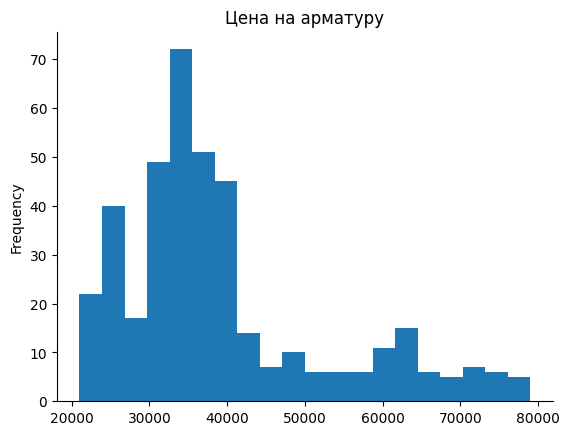

In [ ]:
# @title Цена на арматуру

from matplotlib import pyplot as plt
df_train['Цена на арматуру'].plot(kind='hist', bins=20, title='Цена на арматуру')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
df.shape

(400, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   dt                400 non-null    datetime64[ns]
 1   Цена на арматуру  400 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.4 KB


нулевых значений нет

<Axes: ylabel='Цена на арматуру'>

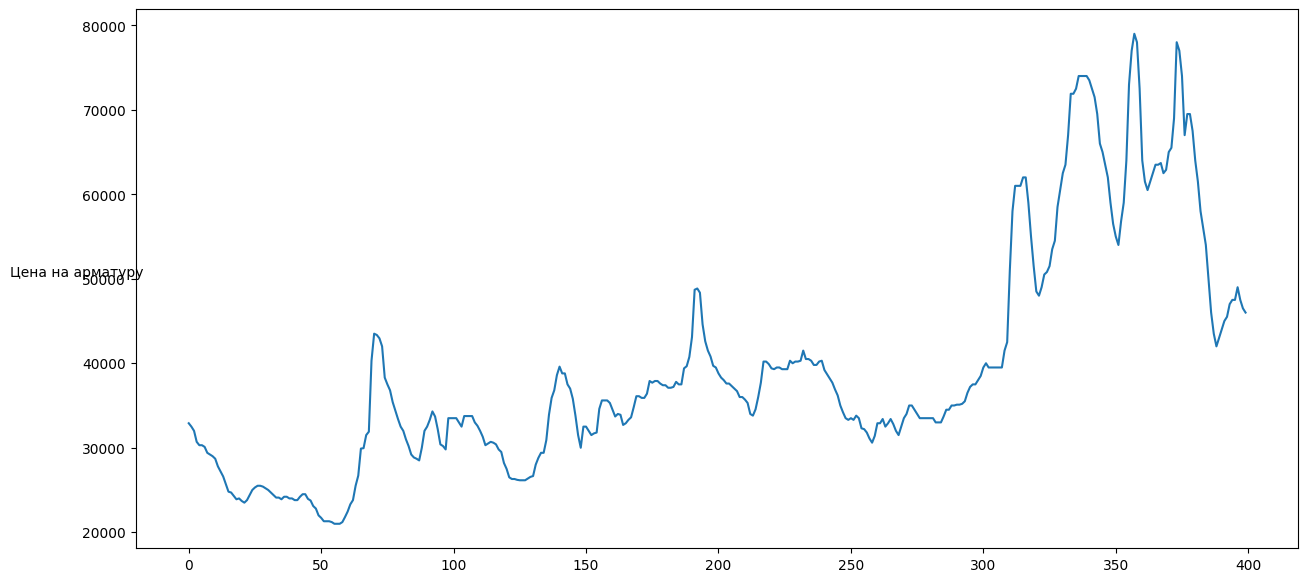

In [ ]:
plt.figure(figsize=(15, 7))
plt.ylabel('Цена на арматуру', rotation=0)
df['Цена на арматуру'].plot()

Судя по графику, временной ряд случайный. Однако, можно предположить, что он все таки увеличивается. Чтобы не гадать, можно это проверить

In [ ]:
!pip install statsmodels==0.14.4

In [ ]:
df["Цена на арматуру"]

,Цена на арматуру
0,32900
1,32500
2,32000
3,30700
4,30300
...,...
395,47500
396,49000
397,47500
398,46500


In [ ]:
df.describe()

,Цена на арматуру
count,400.000000
mean,39229.475000
std,13407.979668
min,21000.000000
25%,31075.000000
50%,35450.000000
75%,42000.000000
max,79000.000000


Приводим дату к формату даты и делаем её индексом

In [ ]:
df['dt'] = pd.to_datetime(df['dt'], format='%m-%d-%Y')

df = df.set_index(['dt'])

Разложение ряда на компоненты

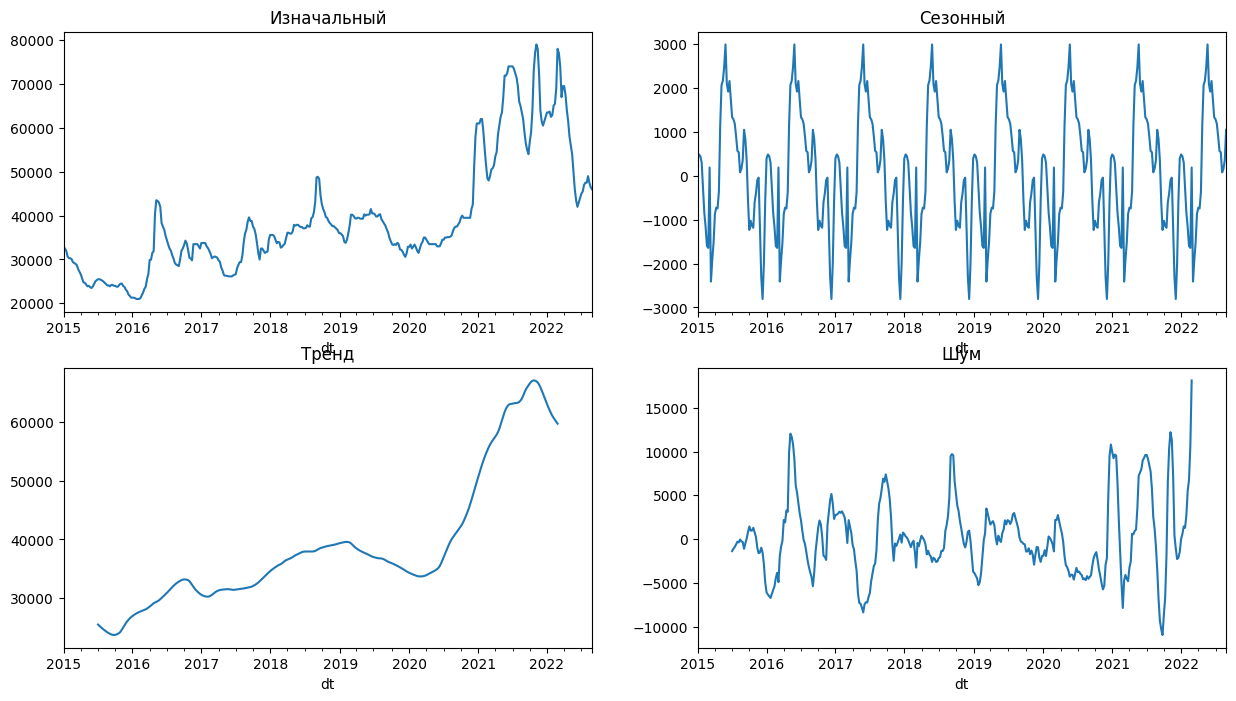

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,8))

decompose = seasonal_decompose(df[['Цена на арматуру']])

ax[0, 0].set_title('Изначальный')
ax[0, 1].set_title('Сезонный')
ax[1, 0].set_title('Тренд')
ax[1, 1].set_title('Шум')

decompose.observed.plot(ax=ax[0, 0])
decompose.seasonal.plot(ax=ax[0, 1])
decompose.trend.plot(ax=ax[1, 0])
decompose.resid.plot(ax=ax[1, 1]);


Тест на стационарность

In [ ]:
from statsmodels.tsa.stattools import adfuller, acf

result = adfuller(df['Цена на арматуру'])

print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -1.9258699893713456
p-value: 0.31999061025699155


можно предположить, т.к. p > 0.05, что временной ряд нестационарен

Автокорреляция и частичная автокорреляция

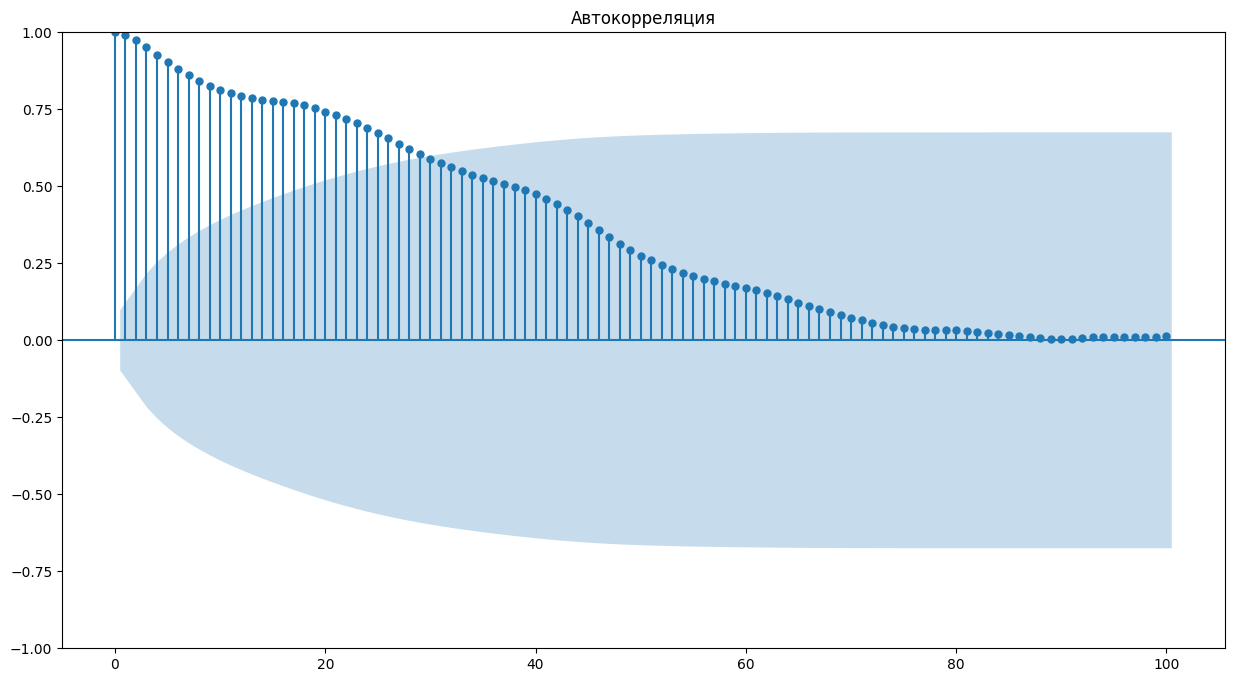

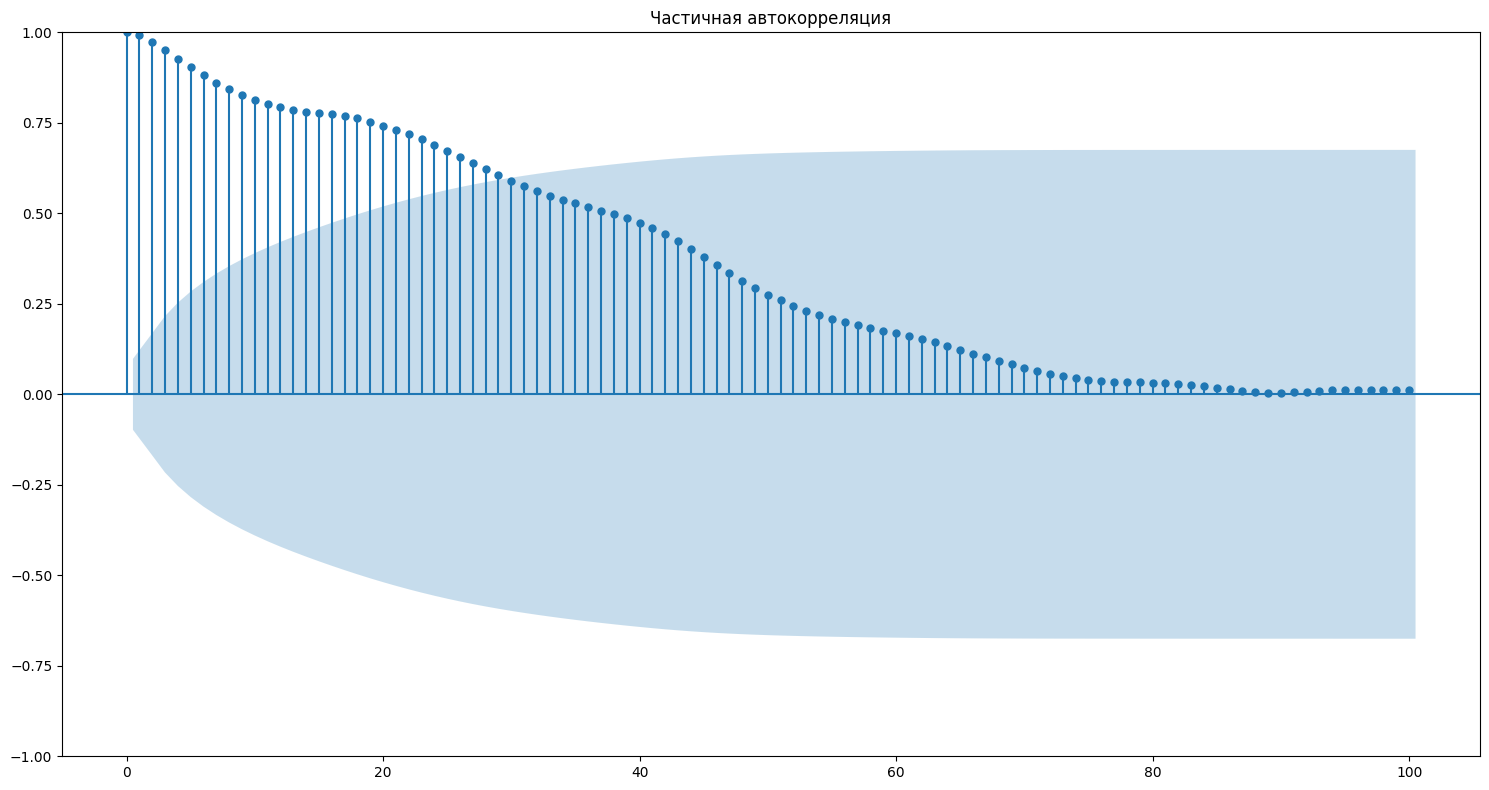

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(15,8))
plot_acf(df['Цена на арматуру'], lags=100, ax=plt.gca())
plt.title('Автокорреляция')

plt.figure(figsize=(15,8))

plot_acf(df['Цена на арматуру'], lags=100, ax=plt.gca())
plt.title('Частичная автокорреляция')

plt.tight_layout()
plt.show()

Надо сделать временной ряд стационарным


модель ARIMA

Экспоненциальное сглаживание

In [ ]:
alpha = 0.4

exp_smoothing = [df['Цена на арматуру'].iloc[0]]

for i in range(1, len(df['Цена на арматуру'])):
  exp_smoothing.append(alpha*df['Цена на арматуру'].iloc[i] + (1-alpha)*exp_smoothing[i-1])

print(exp_smoothing[-2])

47182.1182616193


In [ ]:
from datetime import timedelta

last_day = df.iloc[[-1]].index

last_day = last_day + timedelta(days=1)

last_day


TypeError: Concatenation operation is not implemented for NumPy arrays, use np.concatenate() instead. Please do not rely on this error; it may not be given on all Python implementations.

In [ ]:
df.columns

Index(['Цена на арматуру', 'exp_smoothing'], dtype='object')

In [ ]:
from statsmodels.tsa.ar_model import AutoReg

auto_reg_model = AutoReg(df, lags=[10, 100, 200], seasonal=True, period=12).fit()

auto_reg_model.summary()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                AutoReg Model Results                                
=====================================================================================
Dep. Variable:              Цена на арматуру   No. Observations:                  400
Model:             Restr. Seas. AutoReg(200)   Log Likelihood               -2104.793
Method:                      Conditional MLE   S.D. of innovations           9000.413
Date:                       Tue, 18 Mar 2025   AIC                           4241.586
Time:                               11:13:22   BIC                           4294.359
Sample:                           11-05-2018   HQIC                          4262.942
                                - 08-29-2022                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -2128.0336   6420.251     -0.331      0.740   -1.47e+04    1.05e+04
s(2,12)                 379.1582   3087.708      0.123      0.902   -5672.638    6430.955
s(3,12)                -105.0726   3087.970     -0.034      0.973   -6157.383    5947.238
s(4,12)                -752.9287   3089.739     -0.244      0.807   -6808.705    5302.848
s(5,12)               -1005.9230   3137.223     -0.321      0.748   -7154.767    5142.921
s(6,12)                -988.5368   3137.445     -0.315      0.753   -7137.816    5160.742
s(7,12)                -549.3147   3136.106     -0.175      0.861   -6695.969    5597.339
s(8,12)                -377.6945   3137.305     -0.120      0.904   -6526.700    5771.311
s(9,12)               -1049.9512   3090.642     -0.340      0.734   -7107.498    5007.595
s(10,12)              -1049.1331   3088.852     -0.340      0.734   -7103.171    5004.905
s(11,12)               -393.5990   3087.543     -0.127      0.899   -6445.071    5657.873
s(12,12)               -430.5881   3087.345     -0.139      0.889   -6481.673    5620.497
Цена на арматуру.L10      0.7345      0.052     14.246      0.000       0.633       0.836
Цена на арматуру.L100     0.3310      0.164      2.023      0.043       0.010       0.652
Цена на арматуру.L200     0.1170      0.122      0.958      0.338      -0.122       0.356
                                     Roots                                     
===============================================================================
                    Real          Imaginary           Modulus         Frequency
-------------------------------------------------------------------------------
AR.1             -0.8062           -0.5857j            0.9965           -0.4000
AR.2             -0.8062           +0.5857j            0.9965            0.4000
AR.3             -0.7760           -0.6336j            1.0019           -0.3910
AR.4             -0.7760           +0.6336j            1.0019            0.3910
AR.5             -0.8010           -0.6194j            1.0125           -0.3952
AR.6             -0.8010           +0.6194j            1.0125            0.3952
AR.7             -0.8424           -0.5422j            1.0019           -0.4090
AR.8             -0.8424           +0.5422j            1.0019            0.4090
AR.9             -0.8365           -0.5704j            1.0125           -0.4048
AR.10            -0.8365           +0.5704j            1.0125            0.4048
AR.11            -0.8793           -0.4899j            1.0065           -0.4191
AR.12            -0.8793           +0.4899j            1.0065            0.4191
AR.13            -0.8720           -0.5187j            1.0146           -0.4146
AR.14            -0.8720           +0.5187j            1.0146            0.4146
AR.15            -0.7627           -0.6690j            1.0146           -0.3854
AR.16            -0.7627           +0.

In [ ]:
df['exp_smoothing'] = exp_smoothing

df.head(20)

,Цена на арматуру,exp_smoothing
dt,,
2015-01-05,32900,32900.000000
2015-01-12,32500,32740.000000
2015-01-19,32000,32444.000000
2015-01-26,30700,31746.400000
2015-02-02,30300,31167.840000
2015-02-09,30300,30820.704000
2015-02-16,30100,30532.422400
2015-02-23,29400,30079.453440
2015-03-02,29200,29727.672064
